# CH 14 - Data Analysis Examples

## 14.1 1.USA.gov Data from Bitly

* In 2011, URL shortening service Bitly partnered with the US government website USA.gov to provide a feed of anonymous data gathered from users who shorten links ending with .gov or .mil. 

#### If we read just the first line of a file we may see something like this:

In [1]:
path = 'examples/datasets/bitly_usagov/example.txt'

open(path).readline()

'{ "a": "Mozilla\\/5.0 (Windows NT 6.1; WOW64) AppleWebKit\\/535.11 (KHTML, like Gecko) Chrome\\/17.0.963.78 Safari\\/535.11", "c": "US", "nk": 1, "tz": "America\\/New_York", "gr": "MA", "g": "A6qOVH", "h": "wfLQtf", "l": "orofrog", "al": "en-US,en;q=0.8", "hh": "1.usa.gov", "r": "http:\\/\\/www.facebook.com\\/l\\/7AQEFzjSi\\/1.usa.gov\\/wfLQtf", "u": "http:\\/\\/www.ncbi.nlm.nih.gov\\/pubmed\\/22415991", "t": 1331923247, "hc": 1331822918, "cy": "Danvers", "ll": [ 42.576698, -70.954903 ] }\n'

#### Here we’ll use the json module and its loads function invoked on each line in the sample file we downloaded

In [2]:
import json

records = [json.loads(line) for line in open(path)]

In [3]:
records[0]

{'a': 'Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/535.11 (KHTML, like Gecko) Chrome/17.0.963.78 Safari/535.11',
 'c': 'US',
 'nk': 1,
 'tz': 'America/New_York',
 'gr': 'MA',
 'g': 'A6qOVH',
 'h': 'wfLQtf',
 'l': 'orofrog',
 'al': 'en-US,en;q=0.8',
 'hh': '1.usa.gov',
 'r': 'http://www.facebook.com/l/7AQEFzjSi/1.usa.gov/wfLQtf',
 'u': 'http://www.ncbi.nlm.nih.gov/pubmed/22415991',
 't': 1331923247,
 'hc': 1331822918,
 'cy': 'Danvers',
 'll': [42.576698, -70.954903]}

### Counting Time Zones with pandas

In [4]:
import pandas as pd

frame = pd.DataFrame(records)

frame.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3560 entries, 0 to 3559
Data columns (total 18 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   a            3440 non-null   object 
 1   c            2919 non-null   object 
 2   nk           3440 non-null   float64
 3   tz           3440 non-null   object 
 4   gr           2919 non-null   object 
 5   g            3440 non-null   object 
 6   h            3440 non-null   object 
 7   l            3440 non-null   object 
 8   al           3094 non-null   object 
 9   hh           3440 non-null   object 
 10  r            3440 non-null   object 
 11  u            3440 non-null   object 
 12  t            3440 non-null   float64
 13  hc           3440 non-null   float64
 14  cy           2919 non-null   object 
 15  ll           2919 non-null   object 
 16  _heartbeat_  120 non-null    float64
 17  kw           93 non-null     object 
dtypes: float64(4), object(14)
memory usage: 500.8+ K

In [5]:
frame['tz'][:10]

0     America/New_York
1       America/Denver
2     America/New_York
3    America/Sao_Paulo
4     America/New_York
5     America/New_York
6        Europe/Warsaw
7                     
8                     
9                     
Name: tz, dtype: object

In [6]:
tz_counts = frame['tz'].value_counts()

tz_counts[:10]

America/New_York       1251
                        521
America/Chicago         400
America/Los_Angeles     382
America/Denver          191
Europe/London            74
Asia/Tokyo               37
Pacific/Honolulu         36
Europe/Madrid            35
America/Sao_Paulo        33
Name: tz, dtype: int64

* We replace the missing values with the `fillna` method and use boolean array indexing for the empty strings:

In [7]:
clean_tz = frame['tz'].fillna('Missing')

clean_tz[clean_tz == ''] = 'Unknown'

tz_counts = clean_tz.value_counts()

tz_counts[:10]

America/New_York       1251
Unknown                 521
America/Chicago         400
America/Los_Angeles     382
America/Denver          191
Missing                 120
Europe/London            74
Asia/Tokyo               37
Pacific/Honolulu         36
Europe/Madrid            35
Name: tz, dtype: int64

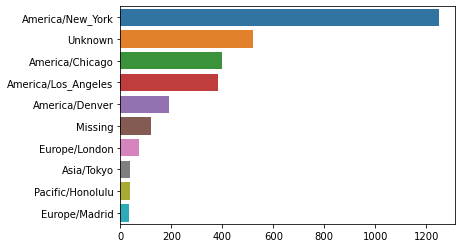

In [8]:
import seaborn as sns

subset = tz_counts[:10]

sns.barplot(y=subset.index, x=subset.values)

* The `a` field contains information about the browser, device, or application used to erform the URL shortening. One possible strategy is to split off the first token in the string (corresponding roughly to the browser capability).

In [9]:
frame['a'][50]

'Mozilla/5.0 (Windows NT 5.1; rv:10.0.2) Gecko/20100101 Firefox/10.0.2'

In [10]:
results = pd.Series([x.split()[0] for x in frame.a.dropna()])

results[:5]

0               Mozilla/5.0
1    GoogleMaps/RochesterNY
2               Mozilla/4.0
3               Mozilla/5.0
4               Mozilla/5.0
dtype: object

In [11]:
results.value_counts()[:8]

Mozilla/5.0                 2594
Mozilla/4.0                  601
GoogleMaps/RochesterNY       121
Opera/9.80                    34
TEST_INTERNET_AGENT           24
GoogleProducer                21
Mozilla/6.0                    5
BlackBerry8520/5.0.0.681       4
dtype: int64

#### Now, suppose you wanted to decompose the top time zones into Windows and nonWindows users. 

In [12]:
import numpy as np

cframe = frame.copy()[frame.a.notnull()]

cframe['os'] = np.where(cframe['a'].str.contains('Windows'), 'Windows', 'Not Windows')

cframe['os'][:5]

0        Windows
1    Not Windows
2        Windows
3    Not Windows
4        Windows
Name: os, dtype: object

In [13]:
# Then, you can group the data by its time zone column and this new list of operating systems
by_tz_os = cframe.groupby(['tz',  'os'])

* The group counts, analogous to the `value_counts` function, can be computed with size. This result is then reshaped into a table with `unstack`.

In [14]:
agg_counts = by_tz_os.size()

agg_counts[:10]

tz                              os         
                                Not Windows    245
                                Windows        276
Africa/Cairo                    Windows          3
Africa/Casablanca               Windows          1
Africa/Ceuta                    Windows          2
Africa/Johannesburg             Windows          1
Africa/Lusaka                   Windows          1
America/Anchorage               Not Windows      4
                                Windows          1
America/Argentina/Buenos_Aires  Not Windows      1
dtype: int64

In [15]:
agg_counts = agg_counts.unstack().fillna(0)

agg_counts[:10]

os,Not Windows,Windows
tz,,
,245.0,276.0
Africa/Cairo,0.0,3.0
Africa/Casablanca,0.0,1.0
Africa/Ceuta,0.0,2.0
Africa/Johannesburg,0.0,1.0
Africa/Lusaka,0.0,1.0
America/Anchorage,4.0,1.0
America/Argentina/Buenos_Aires,1.0,0.0
America/Argentina/Cordoba,0.0,1.0


* Finally, let’s select the top overall time zones. To do so, I construct an indirect index array from the row counts in `agg_counts`

In [16]:
indexer = agg_counts.sum(1).argsort()

indexer[:10]

tz
                                  24
Africa/Cairo                      20
Africa/Casablanca                 21
Africa/Ceuta                      92
Africa/Johannesburg               87
Africa/Lusaka                     53
America/Anchorage                 54
America/Argentina/Buenos_Aires    57
America/Argentina/Cordoba         26
America/Argentina/Mendoza         55
dtype: int64

* I use take to select the rows in that order, then slice off the last 10 rows (largest values):

In [17]:
count_subset = agg_counts.take(indexer[-10:])

count_subset

os,Not Windows,Windows
tz,,
America/Sao_Paulo,13.0,20.0
Europe/Madrid,16.0,19.0
Pacific/Honolulu,0.0,36.0
Asia/Tokyo,2.0,35.0
Europe/London,43.0,31.0
America/Denver,132.0,59.0
America/Los_Angeles,130.0,252.0
America/Chicago,115.0,285.0
,245.0,276.0


#### `pandas` has a convenience method called `nlargest` that does the same thing:

In [18]:
agg_counts.sum(1).nlargest(10)

tz
America/New_York       1251.0
                        521.0
America/Chicago         400.0
America/Los_Angeles     382.0
America/Denver          191.0
Europe/London            74.0
Asia/Tokyo               37.0
Pacific/Honolulu         36.0
Europe/Madrid            35.0
America/Sao_Paulo        33.0
dtype: float64

In [19]:
count_subset

os,Not Windows,Windows
tz,,
America/Sao_Paulo,13.0,20.0
Europe/Madrid,16.0,19.0
Pacific/Honolulu,0.0,36.0
Asia/Tokyo,2.0,35.0
Europe/London,43.0,31.0
America/Denver,132.0,59.0
America/Los_Angeles,130.0,252.0
America/Chicago,115.0,285.0
,245.0,276.0


In [20]:
count_subset = count_subset.stack()

count_subset.name = 'total'

count_subset = count_subset.reset_index()

count_subset[:10]

,tz,os,total
0,America/Sao_Paulo,Not Windows,13.0
1,America/Sao_Paulo,Windows,20.0
2,Europe/Madrid,Not Windows,16.0
3,Europe/Madrid,Windows,19.0
4,Pacific/Honolulu,Not Windows,0.0
5,Pacific/Honolulu,Windows,36.0
6,Asia/Tokyo,Not Windows,2.0
7,Asia/Tokyo,Windows,35.0
8,Europe/London,Not Windows,43.0
9,Europe/London,Windows,31.0


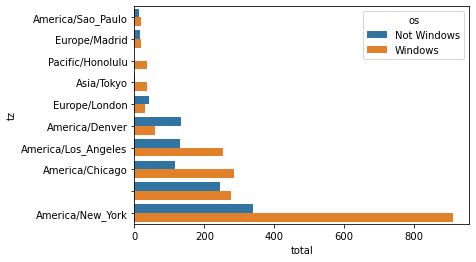

In [21]:
sns.barplot(x='total', y='tz', hue='os', data=count_subset);

* The plot doesn’t make it easy to see the relative percentage of Windows users in the smaller groups, so let’s normalize the group percentages to sum to 1:

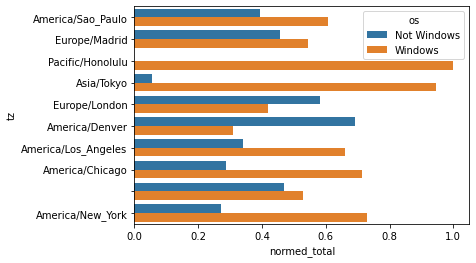

In [22]:
def norm_total(group):
    group['normed_total'] = group.total / group.total.sum()
    return group

results = count_subset.groupby('tz').apply(norm_total)

sns.barplot(x='normed_total', y='tz', hue='os', data=results);

* We could have computed the normalized sum more efficiently by using the `transform` method with `groupby`:

In [23]:
g  = count_subset.groupby('tz')

results2 = count_subset.total / g.total.transform('sum')

results2[:10]

0    0.393939
1    0.606061
2    0.457143
3    0.542857
4    0.000000
5    1.000000
6    0.054054
7    0.945946
8    0.581081
9    0.418919
Name: total, dtype: float64

## 14.2 MovieLens 1M Dataset

* The MovieLens 1M dataset contains 1 million ratings collected from 6,000 users on 4,000 movies. It’s spread across three tables: ratings, user information, and movie information. 

In [24]:
pd.options.display.max_rows = 10

unames = ['user_id', 'gender', 'age', 'ocupation', 'zip']
users = pd.read_table('examples/datasets/movielens/users.dat', sep='::', 
                      header=None, names=unames, engine='python')

rnames = ['user_id', 'movie_id', 'rating', 'timestamp']
ratings = pd.read_table('examples/datasets/movielens/ratings.dat', sep='::', 
                        header=None, names=rnames, engine='python')

mnames = ['movie_id', 'title', 'genres']
movies = pd.read_table('examples/datasets/movielens/movies.dat', sep='::', 
                       header=None, names=mnames, engine='python')

In [25]:
users[:5]

,user_id,gender,age,ocupation,zip
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455


In [26]:
ratings[:5]

,user_id,movie_id,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [27]:
movies[:5]

,movie_id,title,genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


* Using pandas’s `merge` function, we first merge `ratings` with `users` and then merge that result with the `movies` data. pandas infers which columns to use as the merge (or join) keys based on overlapping names

In [28]:
data = pd.merge(pd.merge(ratings, users), movies)

In [29]:
data.head()

,user_id,movie_id,rating,timestamp,gender,age,ocupation,zip,title,genres
0,1,1193,5,978300760,F,1,10,48067,One Flew Over the Cuckoo's Nest (1975),Drama
1,2,1193,5,978298413,M,56,16,70072,One Flew Over the Cuckoo's Nest (1975),Drama
2,12,1193,4,978220179,M,25,12,32793,One Flew Over the Cuckoo's Nest (1975),Drama
3,15,1193,4,978199279,M,25,7,22903,One Flew Over the Cuckoo's Nest (1975),Drama
4,17,1193,5,978158471,M,50,1,95350,One Flew Over the Cuckoo's Nest (1975),Drama


* To get mean movie ratings for each film grouped by gender, we can use the
`pivot_table` method:

In [30]:
mean_ratings = data.pivot_table('rating', index='title', 
                                columns='gender', aggfunc='mean')

mean_ratings[:5]

gender,F,M
title,,
"$1,000,000 Duck (1971)",3.375000,2.761905
'Night Mother (1986),3.388889,3.352941
'Til There Was You (1997),2.675676,2.733333
"'burbs, The (1989)",2.793478,2.962085
...And Justice for All (1979),3.828571,3.689024


In [31]:
ratings_by_title = data.groupby('title').size()

ratings_by_title[:10]

title
$1,000,000 Duck (1971)                37
'Night Mother (1986)                  70
'Til There Was You (1997)             52
'burbs, The (1989)                   303
...And Justice for All (1979)        199
1-900 (1994)                           2
10 Things I Hate About You (1999)    700
101 Dalmatians (1961)                565
101 Dalmatians (1996)                364
12 Angry Men (1957)                  616
dtype: int64

In [32]:
# s. I first filter down to movies that received at least 250 ratings (a completely arbitrary number)
active_titles = ratings_by_title.index[ratings_by_title >= 250]

active_titles

Index([''burbs, The (1989)', '10 Things I Hate About You (1999)',
       '101 Dalmatians (1961)', '101 Dalmatians (1996)', '12 Angry Men (1957)',
       '13th Warrior, The (1999)', '2 Days in the Valley (1996)',
       '20,000 Leagues Under the Sea (1954)', '2001: A Space Odyssey (1968)',
       '2010 (1984)',
       ...
       'X-Men (2000)', 'Year of Living Dangerously (1982)',
       'Yellow Submarine (1968)', 'You've Got Mail (1998)',
       'Young Frankenstein (1974)', 'Young Guns (1988)',
       'Young Guns II (1990)', 'Young Sherlock Holmes (1985)',
       'Zero Effect (1998)', 'eXistenZ (1999)'],
      dtype='object', name='title', length=1216)

In [33]:
# The index of titles receiving at least 250 ratings can then be used to select rows from mean_ratings

mean_ratings = mean_ratings.loc[active_titles]

mean_ratings

gender,F,M
title,,
"'burbs, The (1989)",2.793478,2.962085
10 Things I Hate About You (1999),3.646552,3.311966
101 Dalmatians (1961),3.791444,3.500000
101 Dalmatians (1996),3.240000,2.911215
12 Angry Men (1957),4.184397,4.328421
...,...,...
Young Guns (1988),3.371795,3.425620
Young Guns II (1990),2.934783,2.904025
Young Sherlock Holmes (1985),3.514706,3.363344


In [34]:
# To see the top films among female viewers, we can sort by the F column in descending order
top_female_ratings = mean_ratings.sort_values(by='F', ascending=False)

top_female_ratings[:10]

gender,F,M
title,,
"Close Shave, A (1995)",4.644444,4.473795
"Wrong Trousers, The (1993)",4.588235,4.478261
Sunset Blvd. (a.k.a. Sunset Boulevard) (1950),4.572650,4.464589
Wallace & Gromit: The Best of Aardman Animation (1996),4.563107,4.385075
Schindler's List (1993),4.562602,4.491415
"Shawshank Redemption, The (1994)",4.539075,4.560625
"Grand Day Out, A (1992)",4.537879,4.293255
To Kill a Mockingbird (1962),4.536667,4.372611
Creature Comforts (1990),4.513889,4.272277


### Measuring Rating Disagreement

Suppose you wanted to find the movies that are most divisive between male and female viewers. 

In [35]:
mean_ratings['diff'] = mean_ratings['M'] - mean_ratings['F']

sorted_by_diff = mean_ratings.sort_values(by='diff')

In [36]:
# Sorting by 'diff' yields the movies with the greatest rating difference 
# so that we can see which ones were preferred by women
sorted_by_diff[:10]

gender,F,M,diff
title,,,
Dirty Dancing (1987),3.790378,2.959596,-0.830782
Jumpin' Jack Flash (1986),3.254717,2.578358,-0.676359
Grease (1978),3.975265,3.367041,-0.608224
Little Women (1994),3.870588,3.321739,-0.548849
Steel Magnolias (1989),3.901734,3.365957,-0.535777
Anastasia (1997),3.800000,3.281609,-0.518391
"Rocky Horror Picture Show, The (1975)",3.673016,3.160131,-0.512885
"Color Purple, The (1985)",4.158192,3.659341,-0.498851
"Age of Innocence, The (1993)",3.827068,3.339506,-0.487561


In [37]:
# Reversing the order of the rows and again slicing off the top 10 rows, we get
# the movies preferred by men that women didn’t rate as highly
sorted_by_diff[::-1][:10]

gender,F,M,diff
title,,,
"Good, The Bad and The Ugly, The (1966)",3.494949,4.221300,0.726351
"Kentucky Fried Movie, The (1977)",2.878788,3.555147,0.676359
Dumb & Dumber (1994),2.697987,3.336595,0.638608
"Longest Day, The (1962)",3.411765,4.031447,0.619682
"Cable Guy, The (1996)",2.250000,2.863787,0.613787
Evil Dead II (Dead By Dawn) (1987),3.297297,3.909283,0.611985
"Hidden, The (1987)",3.137931,3.745098,0.607167
Rocky III (1982),2.361702,2.943503,0.581801
Caddyshack (1980),3.396135,3.969737,0.573602


* Suppose instead you wanted the movies that elicited the most disagreement among viewers, independent of gender identification. Disagreement can be measured by the variance or standard deviation of the ratings

In [38]:
# Standard deviation of rating grouped by title
rating_std_by_title = data.groupby('title')['rating'].std()

# Filter down to active_titles
rating_std_by_title = rating_std_by_title.loc[active_titles]

# Order Series by value in descending order
rating_std_by_title.sort_values(ascending=False)[:10]

title
Dumb & Dumber (1994)                     1.321333
Blair Witch Project, The (1999)          1.316368
Natural Born Killers (1994)              1.307198
Tank Girl (1995)                         1.277695
Rocky Horror Picture Show, The (1975)    1.260177
Eyes Wide Shut (1999)                    1.259624
Evita (1996)                             1.253631
Billy Madison (1995)                     1.249970
Fear and Loathing in Las Vegas (1998)    1.246408
Bicentennial Man (1999)                  1.245533
Name: rating, dtype: float64

## 14.3 US Baby Names 1880–2010

In [39]:
import pandas as pd

names1880 = pd.read_csv('examples/datasets/babynames/yob1880.txt',
                        names=['name', 'sex', 'births'])

names1880

,name,sex,births
0,Mary,F,7065
1,Anna,F,2604
2,Emma,F,2003
3,Elizabeth,F,1939
4,Minnie,F,1746
...,...,...,...
1995,Woodie,M,5
1996,Worthy,M,5
1997,Wright,M,5
1998,York,M,5


In [40]:
# we can use the sum of the births column by sex as the total number of births in that year

names1880.groupby('sex').births.sum()

sex
F     90993
M    110493
Name: births, dtype: int64

* Since the dataset is split into files by year, one of the first things to do is to assemble
all of the data into a single DataFrame and further to add a year field

In [41]:
years = range(1880, 2011)

pieces = []

columns = ['name', 'sex', 'births']

for year in years:
    path = f'examples/datasets/babynames/yob{year:d}.txt'
    frame = pd.read_csv(path, names=columns)
    
    frame['year'] = year
    pieces.append(frame)

names = pd.concat(pieces, ignore_index=True)

In [42]:
names.head()

,name,sex,births,year
0,Mary,F,7065,1880
1,Anna,F,2604,1880
2,Emma,F,2003,1880
3,Elizabeth,F,1939,1880
4,Minnie,F,1746,1880


* With this data in hand, we can already start aggregating the data at the year and sex level using `groupby` or `pivot_table`. 

In [43]:
total_births = names.pivot_table('births', index='year', columns='sex', aggfunc=sum)

total_births.tail()

sex,F,M
year,,
2006,1896468,2050234
2007,1916888,2069242
2008,1883645,2032310
2009,1827643,1973359
2010,1759010,1898382


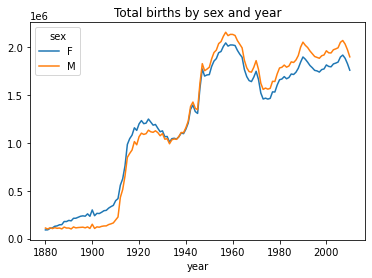

In [44]:
total_births.plot(title='Total births by sex and year');

In [45]:
# Next, let’s insert a column prop with the fraction of babies given each 
# name relative to the total number of births. 
def add_prop(group):
    group['prop'] = group.births / group.births.sum()
    return group

names = names.groupby(['year', 'sex']).apply(add_prop)

In [46]:
names

,name,sex,births,year,prop
0,Mary,F,7065,1880,0.077643
1,Anna,F,2604,1880,0.028618
2,Emma,F,2003,1880,0.022013
3,Elizabeth,F,1939,1880,0.021309
4,Minnie,F,1746,1880,0.019188
...,...,...,...,...,...
1690779,Zymaire,M,5,2010,0.000003
1690780,Zyonne,M,5,2010,0.000003
1690781,Zyquarius,M,5,2010,0.000003
1690782,Zyran,M,5,2010,0.000003


In [47]:
# sanity check
names.groupby(['year', 'sex']).prop.sum()

year  sex
1880  F      1.0
      M      1.0
1881  F      1.0
      M      1.0
1882  F      1.0
            ... 
2008  M      1.0
2009  F      1.0
      M      1.0
2010  F      1.0
      M      1.0
Name: prop, Length: 262, dtype: float64

*  Now that this is done, I’m going to extract a subset of the data to facilitate further analysis: the top 1,000 names for each sex/year combination

In [48]:
def get_top1000(group):
    return group.sort_values(by='births', ascending=False)[:1000]

grouped  = names.groupby(['year', 'sex'])
top1000 = grouped.apply(get_top1000)

top1000.reset_index(inplace=True, drop=True)

top1000

,name,sex,births,year,prop
0,Mary,F,7065,1880,0.077643
1,Anna,F,2604,1880,0.028618
2,Emma,F,2003,1880,0.022013
3,Elizabeth,F,1939,1880,0.021309
4,Minnie,F,1746,1880,0.019188
...,...,...,...,...,...
261872,Camilo,M,194,2010,0.000102
261873,Destin,M,194,2010,0.000102
261874,Jaquan,M,194,2010,0.000102
261875,Jaydan,M,194,2010,0.000102


### Analyzing Naming Trends

In [49]:
boys = top1000[top1000.sex == 'M']
girls = top1000[top1000.sex == 'F']

In [50]:
total_births = top1000.pivot_table('births', index='year',
                                   columns='name', aggfunc=sum)
total_births.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 131 entries, 1880 to 2010
Columns: 6868 entries, Aaden to Zuri
dtypes: float64(6868)
memory usage: 6.9 MB


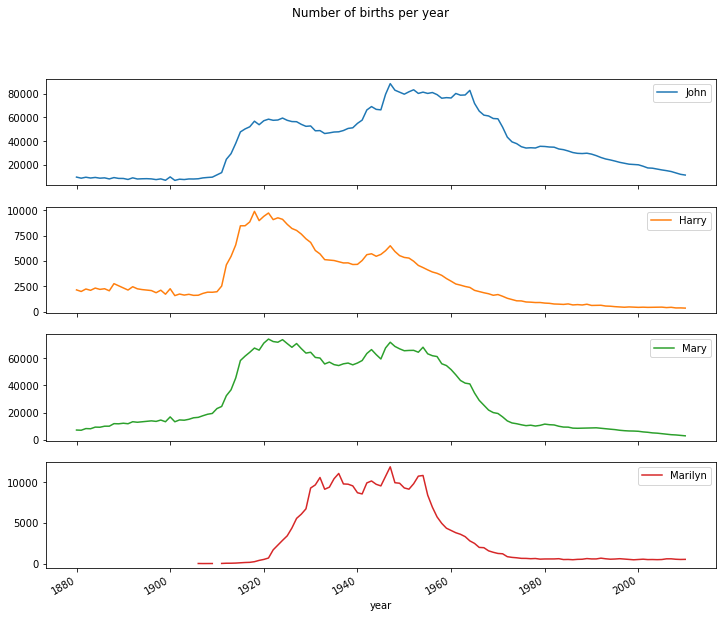

In [51]:
subset = total_births[['John', 'Harry', 'Mary', 'Marilyn']]

subset.plot(subplots=True, figsize=(12, 10), grid=False,
            title='Number of births per year');

#### Measuring the increase in naming diversity

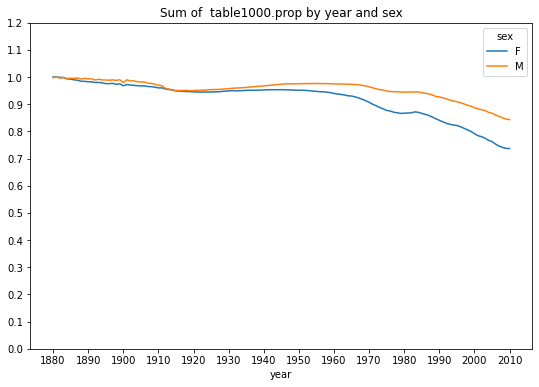

In [52]:
table = top1000.pivot_table('prop', index='year', columns='sex', aggfunc=sum)

table.plot(title='Sum of  table1000.prop by year and sex',
           yticks=np.linspace(0, 1.2, 13), xticks=range(1880, 2020, 10), figsize=(9,6));

In [53]:
np.linspace(0, 1.2, 13)

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2])

In [54]:
df = boys[boys.year == 2010]

In [55]:
df

,name,sex,births,year,prop
260877,Jacob,M,21875,2010,0.011523
260878,Ethan,M,17866,2010,0.009411
260879,Michael,M,17133,2010,0.009025
260880,Jayden,M,17030,2010,0.008971
260881,William,M,16870,2010,0.008887
...,...,...,...,...,...
261872,Camilo,M,194,2010,0.000102
261873,Destin,M,194,2010,0.000102
261874,Jaquan,M,194,2010,0.000102
261875,Jaydan,M,194,2010,0.000102


* After sorting prop in descending order, we want to know how many of the most popular names it takes to reach 50%.

In [56]:
prop_cumsum = df.sort_values(by='prop', ascending=False)['prop'].cumsum()

prop_cumsum[:10]

260877    0.011523
260878    0.020934
260879    0.029959
260880    0.038930
260881    0.047817
260882    0.056579
260883    0.065155
260884    0.073414
260885    0.081528
260886    0.089621
Name: prop, dtype: float64

In [57]:
prop_cumsum.values.searchsorted(.5)

116

* Since arrays are zero-indexed, adding 1 to this result gives you a result of 117. By contrast, in 1900 this number was much smaller

In [58]:
df = boys[boys.year == 1900]

in1900 = df.sort_values('prop', ascending=False)['prop'].cumsum()

in1900.values.searchsorted(.5) + 1

25

* You can now apply this operation to each year/sex combination, groupby those fields,
and apply a function returning the count for each group

In [59]:
def get_quantile_count(group, q=0.5):
    group = group.sort_values('prop', ascending=False)
    return group['prop'].cumsum().values.searchsorted(q) + 1

In [60]:
diversity = top1000.groupby(['year', 'sex']).apply(get_quantile_count)
diversity = diversity.unstack('sex')

diversity.head()

sex,F,M
year,,
1880,38,14
1881,38,14
1882,38,15
1883,39,15
1884,39,16


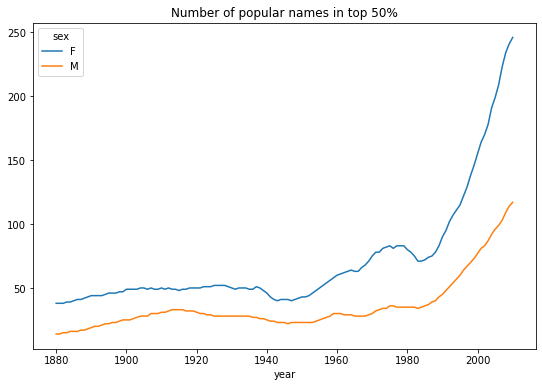

In [61]:
diversity.plot(title='Number of popular names in top 50%', figsize=(9, 6));

### The “last letter” revolution

In [62]:
get_last_letter = lambda x: x[-1]

last_letters = names['name'].map(get_last_letter)

last_letters.name = 'last_letter'

In [63]:
table = names.pivot_table(values='births', index=last_letters, 
                          columns=['sex', 'year'], aggfunc='sum')

table[:5]

sex                F                                                        \
year            1880     1881     1882     1883     1884     1885     1886   
last_letter                                                                  
a            31446.0  31581.0  36536.0  38330.0  43680.0  45408.0  49100.0   
b                NaN      NaN      NaN      NaN      NaN      NaN      NaN   
c                NaN      NaN      5.0      5.0      NaN      NaN      NaN   
d              609.0    607.0    734.0    810.0    916.0    862.0   1007.0   
e            33378.0  34080.0  40399.0  41914.0  48089.0  49616.0  53884.0   

sex                                     ...         M                      \
year            1887     1888     1889  ...      2001      2002      2003   
last_letter                             ...                                 
a            48942.0  59442.0  58631.0  ...   39124.0   38815.0   37825.0   
b                NaN      NaN      NaN  ...   50950.0   49284.0   48065.0   
c                NaN      NaN      NaN  ...   27113.0   27238.0   27697.0   
d             1027.0   1298.0   1374.0  ...   60838.0   55829.0   53391.0   
e            54353.0  66750.0  66663.0  ...  145395.0  144651.0  144769.0   

sex                                                                      \
year             2004      2005      2006      2007      2008      2009   
last_letter                                                               
a             38650.0   36838.0   36156.0   34654.0   32901.0   31430.0   
b             45914.0   43144.0   42600.0   42123.0   39945.0   38862.0   
c             26778.0   26078.0   26635.0   26864.0   25318.0   24048.0   
d             51754.0   50670.0   51410.0   50595.0   47910.0   46172.0   
e            142098.0  141123.0  142999.0  143698.0  140966.0  135496.0   

sex                    
year             2010  
last_letter            
a             28438.0  
b             38859.0  
c             23125.0  
d             44398.0  
e            129012.0  

[5 rows x 262 columns]

In [64]:
# Then we select out three representative years spanning the
# history and print the first few rows:

subtable = table.reindex(columns=[1910, 1960, 2010],  level='year')

subtable.head()

sex                 F                            M                    
year             1910      1960      2010     1910      1960      2010
last_letter                                                           
a            108376.0  691247.0  670605.0    977.0    5204.0   28438.0
b                 NaN     694.0     450.0    411.0    3912.0   38859.0
c                 5.0      49.0     946.0    482.0   15476.0   23125.0
d              6750.0    3729.0    2607.0  22111.0  262112.0   44398.0
e            133569.0  435013.0  313833.0  28655.0  178823.0  129012.0

In [65]:
# Next, normalize the table by total births to compute a new table containing propor‐
# tion of total births for each sex ending in each letter

subtable.sum()

sex  year
F    1910     396416.0
     1960    2022062.0
     2010    1759010.0
M    1910     194198.0
     1960    2132588.0
     2010    1898382.0
dtype: float64

In [66]:
letter_prop = subtable / subtable.sum()
letter_prop

sex                 F                             M                    
year             1910      1960      2010      1910      1960      2010
last_letter                                                            
a            0.273390  0.341853  0.381240  0.005031  0.002440  0.014980
b                 NaN  0.000343  0.000256  0.002116  0.001834  0.020470
c            0.000013  0.000024  0.000538  0.002482  0.007257  0.012181
d            0.017028  0.001844  0.001482  0.113858  0.122908  0.023387
e            0.336941  0.215133  0.178415  0.147556  0.083853  0.067959
...               ...       ...       ...       ...       ...       ...
v                 NaN  0.000060  0.000117  0.000113  0.000037  0.001434
w            0.000020  0.000031  0.001182  0.006329  0.007711  0.016148
x            0.000015  0.000037  0.000727  0.003965  0.001851  0.008614
y            0.110972  0.152569  0.116828  0.077349  0.160987  0.058168
z            0.002439  0.000659  0.000704  0.000170  0.000184  0.001831

[26 rows x 6 columns]

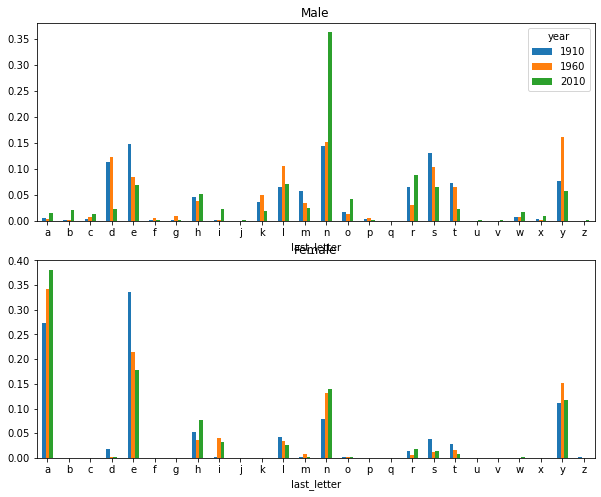

In [67]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 1, figsize=(10, 8))

letter_prop['M'].plot(kind='bar', rot=0, ax=axes[0], title='Male')
letter_prop['F'].plot(kind='bar', rot=0, ax=axes[1], title='Female', legend=False);

* Going back to the full table created before, I again normalize by year and sex
and select a subset of letters for the boy names, finally transposing to make each col‐
umn a time series:

In [68]:
letter_prop = table / table.sum()

dny_ts = letter_prop.loc[['d', 'n', 'y'], 'M'].T

dny_ts.head()

last_letter,d,n,y
year,,,
1880,0.083055,0.153213,0.075760
1881,0.083247,0.153214,0.077451
1882,0.085340,0.149560,0.077537
1883,0.084066,0.151646,0.079144
1884,0.086120,0.149915,0.080405


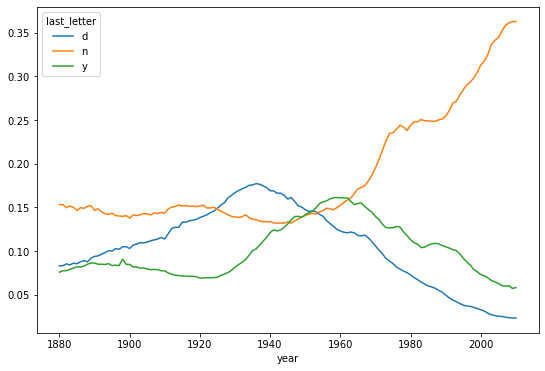

In [69]:
dny_ts.plot(figsize=(9, 6));

### Boy names that became girl names (and vice versa)

Another fun trend is looking at boy names that were more popular with one sex ear‐
lier in the sample but have “changed sexes” in the present. One example is the name
Lesley or Leslie. Going back to the top1000 DataFrame, I compute a list of names
occurring in the dataset starting with “lesl”:

In [70]:
all_names = pd.Series(top1000['name'].unique())

lesley_like = all_names[all_names.str.lower().str.contains('lesl')]

lesley_like

632     Leslie
2294    Lesley
4262    Leslee
4728     Lesli
6103     Lesly
dtype: object

In [71]:
filtered = top1000[top1000['name'].isin(lesley_like)]

filtered.groupby('name').births.sum()

name
Leslee      1082
Lesley     35022
Lesli        929
Leslie    370429
Lesly      10067
Name: births, dtype: int64

In [72]:
table = filtered.pivot_table(values='births', index='year', columns='sex', aggfunc='sum')

table = table.div(table.sum(1), axis=0)

table.tail()

sex,F,M
year,,
2006,1.0,NaN
2007,1.0,NaN
2008,1.0,NaN
2009,1.0,NaN
2010,1.0,NaN


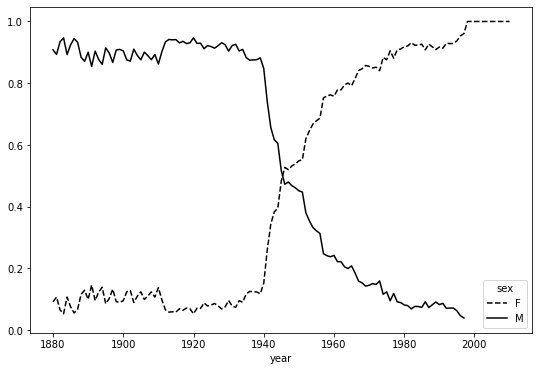

In [73]:
table.plot(style={'M': 'k-', 'F': 'k--'}, figsize=(9, 6));

## 14.4 USDA Food Database

* The US Department of Agriculture makes available a database of food nutrient information.

In [74]:
import json

In [75]:
db = json.load(open('examples/datasets/usda_food/database.json'))

In [76]:
len(db)

6636

In [77]:
# Each entry in db is a dict containing all the data for a single food.
# The 'nutrients' field is a list of dicts, one for each nutrient
db[0].keys()

dict_keys(['id', 'description', 'tags', 'manufacturer', 'group', 'portions', 'nutrients'])

In [78]:
db[0]['nutrients'][0]

{'value': 25.18,
 'units': 'g',
 'description': 'Protein',
 'group': 'Composition'}

In [79]:
nutrients = pd.DataFrame(db[0]['nutrients'])
nutrients[:7]

,value,units,description,group
0,25.18,g,Protein,Composition
1,29.20,g,Total lipid (fat),Composition
2,3.06,g,"Carbohydrate, by difference",Composition
3,3.28,g,Ash,Other
4,376.00,kcal,Energy,Energy
5,39.28,g,Water,Composition
6,1573.00,kJ,Energy,Energy


In [80]:
# When converting a list of dicts to a DataFrame, we can specify a list of fields to extract. 
info_keys = ['description', 'group', 'id', 'manufacturer']

info = pd.DataFrame(db, columns=info_keys)
info[:5]

,description,group,id,manufacturer
0,"Cheese, caraway",Dairy and Egg Products,1008,
1,"Cheese, cheddar",Dairy and Egg Products,1009,
2,"Cheese, edam",Dairy and Egg Products,1018,
3,"Cheese, feta",Dairy and Egg Products,1019,
4,"Cheese, mozzarella, part skim milk",Dairy and Egg Products,1028,


In [81]:
info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6636 entries, 0 to 6635
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   description   6636 non-null   object
 1   group         6636 non-null   object
 2   id            6636 non-null   int64 
 3   manufacturer  5195 non-null   object
dtypes: int64(1), object(3)
memory usage: 207.5+ KB


In [82]:
pd.value_counts(info.group)[:10]

Vegetables and Vegetable Products    812
Beef Products                        618
Baked Products                       496
Breakfast Cereals                    403
Fast Foods                           365
Legumes and Legume Products          365
Lamb, Veal, and Game Products        345
Sweets                               341
Pork Products                        328
Fruits and Fruit Juices              328
Name: group, dtype: int64

* Now, to do some analysis on all of the nutrient data, it’s easiest to assemble the
nutrients for each food into a single large table. To do so, we need to take several
steps. First, I’ll convert each list of food nutrients to a DataFrame, add a column for
the food id, and append the DataFrame to a list. 

In [83]:
df_list = []

for db_item in db:
    df = pd.DataFrame(db_item['nutrients'])
    df['id'] = db_item['id']
    df_list.append(df)

nutrients = pd.concat(df_list, ignore_index=True)
nutrients

,value,units,description,group,id
0,25.180,g,Protein,Composition,1008
1,29.200,g,Total lipid (fat),Composition,1008
2,3.060,g,"Carbohydrate, by difference",Composition,1008
3,3.280,g,Ash,Other,1008
4,376.000,kcal,Energy,Energy,1008
...,...,...,...,...,...
389350,0.000,mcg,"Vitamin B-12, added",Vitamins,43546
389351,0.000,mg,Cholesterol,Other,43546
389352,0.072,g,"Fatty acids, total saturated",Other,43546
389353,0.028,g,"Fatty acids, total monounsaturated",Other,43546


In [84]:
nutrients.duplicated().sum() # number of nutrients

14179

In [85]:
nutrients = nutrients.drop_duplicates()

In [86]:
# Since 'group' and 'description' are in both DataFrame objects, we can rename for clarity
col_mapping = {'description': 'food',
               'group': 'fgroup'}

info = info.rename(columns=col_mapping, copy=False)

In [87]:
info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6636 entries, 0 to 6635
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   food          6636 non-null   object
 1   fgroup        6636 non-null   object
 2   id            6636 non-null   int64 
 3   manufacturer  5195 non-null   object
dtypes: int64(1), object(3)
memory usage: 207.5+ KB


In [88]:
col_mapping = {'description': 'nutrient',
               'group': 'nutgroup'}

nutrients = nutrients.rename(columns=col_mapping, copy=False)

In [89]:
nutrients

,value,units,nutrient,nutgroup,id
0,25.180,g,Protein,Composition,1008
1,29.200,g,Total lipid (fat),Composition,1008
2,3.060,g,"Carbohydrate, by difference",Composition,1008
3,3.280,g,Ash,Other,1008
4,376.000,kcal,Energy,Energy,1008
...,...,...,...,...,...
389350,0.000,mcg,"Vitamin B-12, added",Vitamins,43546
389351,0.000,mg,Cholesterol,Other,43546
389352,0.072,g,"Fatty acids, total saturated",Other,43546
389353,0.028,g,"Fatty acids, total monounsaturated",Other,43546


In [90]:
ndata = pd.merge(nutrients, info, on='id', how='outer')

In [91]:
ndata.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 375176 entries, 0 to 375175
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   value         375176 non-null  float64
 1   units         375176 non-null  object 
 2   nutrient      375176 non-null  object 
 3   nutgroup      375176 non-null  object 
 4   id            375176 non-null  int64  
 5   food          375176 non-null  object 
 6   fgroup        375176 non-null  object 
 7   manufacturer  293054 non-null  object 
dtypes: float64(1), int64(1), object(6)
memory usage: 25.8+ MB


In [92]:
ndata.iloc[30000]

value                                             0.04
units                                                g
nutrient                                       Glycine
nutgroup                                   Amino Acids
id                                                6158
food            Soup, tomato bisque, canned, condensed
fgroup                      Soups, Sauces, and Gravies
manufacturer                                          
Name: 30000, dtype: object

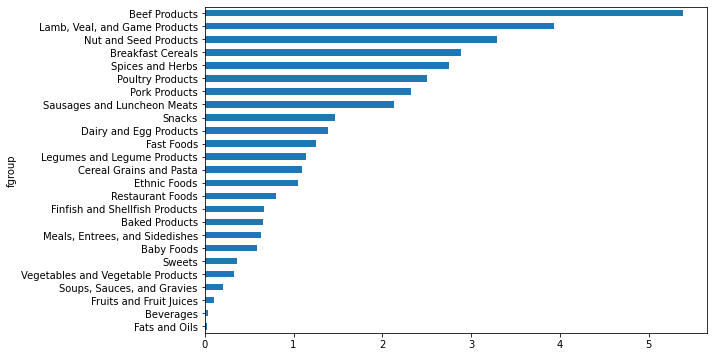

In [93]:
# We could now make a plot of median values by food group and nutrient type 
result = ndata.groupby(['nutrient', 'fgroup'])['value'].quantile(.5)

result['Zinc, Zn'].sort_values().plot(kind='barh', figsize=(9, 6));

In [94]:
# With a little cleverness, you can find which food is most dense in each nutrient
by_nutrient = ndata.groupby(['nutgroup', 'nutrient'])

get_maximum = lambda x: x.loc[x.value.idxmax()]
get_minimum = lambda x: x.loc[x.value.idxmin()] 

max_foods = by_nutrient.apply(get_maximum)[['value', 'food']]

# make the food a little smaller
max_foods.food = max_foods.food.str[:50]

max_foods.loc['Amino Acids'][['food']]

,food
nutrient,
Alanine,"Gelatins, dry powder, unsweetened"
Arginine,"Seeds, sesame flour, low-fat"
Aspartic acid,Soy protein isolate
Cystine,"Seeds, cottonseed flour, low fat (glandless)"
Glutamic acid,Soy protein isolate
...,...
Serine,"Soy protein isolate, PROTEIN TECHNOLOGIES INTE..."
Threonine,"Soy protein isolate, PROTEIN TECHNOLOGIES INTE..."
Tryptophan,"Sea lion, Steller, meat with fat (Alaska Native)"


## 14.5 2012 Federal Election Commission Database

In [95]:
fec = pd.read_csv('examples/datasets/fec/P00000001-ALL.csv', dtype={'contbr_zip': 'str'})

fec.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1001731 entries, 0 to 1001730
Data columns (total 16 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   cmte_id            1001731 non-null  object 
 1   cand_id            1001731 non-null  object 
 2   cand_nm            1001731 non-null  object 
 3   contbr_nm          1001731 non-null  object 
 4   contbr_city        1001712 non-null  object 
 5   contbr_st          1001727 non-null  object 
 6   contbr_zip         1001620 non-null  object 
 7   contbr_employer    988002 non-null   object 
 8   contbr_occupation  993301 non-null   object 
 9   contb_receipt_amt  1001731 non-null  float64
 10  contb_receipt_dt   1001731 non-null  object 
 11  receipt_desc       14166 non-null    object 
 12  memo_cd            92482 non-null    object 
 13  memo_text          97770 non-null    object 
 14  form_tp            1001731 non-null  object 
 15  file_num           1001731 non-n

In [96]:
# A sample record in the DataFrame looks like this
fec.iloc[123456]

cmte_id             C00431445
cand_id             P80003338
cand_nm         Obama, Barack
contbr_nm         ELLMAN, IRA
contbr_city             TEMPE
                    ...      
receipt_desc              NaN
memo_cd                   NaN
memo_text                 NaN
form_tp                 SA17A
file_num               772372
Name: 123456, Length: 16, dtype: object

* You can see that there are no political party affiliations in the data, so this would be
useful to add. You can get a list of all the unique political candidates using `unique`

In [97]:
unique_cands = fec.cand_nm.unique()

In [98]:
unique_cands

array(['Bachmann, Michelle', 'Romney, Mitt', 'Obama, Barack',
       "Roemer, Charles E. 'Buddy' III", 'Pawlenty, Timothy',
       'Johnson, Gary Earl', 'Paul, Ron', 'Santorum, Rick',
       'Cain, Herman', 'Gingrich, Newt', 'McCotter, Thaddeus G',
       'Huntsman, Jon', 'Perry, Rick'], dtype=object)

In [99]:
# One way to indicate party affiliation is using a dict:
parties = {'Bachmann, Michelle': 'Republican',
           'Cain, Herman': 'Republican',
           'Gingrich, Newt': 'Republican',
           'Huntsman, Jon': 'Republican',
           'Johnson, Gary Earl': 'Republican',
           'McCotter, Thaddeus G': 'Republican',
           'Obama, Barack': 'Democrat',
           'Paul, Ron': 'Republican',
           'Pawlenty, Timothy': 'Republican',
           'Perry, Rick': 'Republican',
           "Roemer, Charles E. 'Buddy' III": 'Republican',
           'Romney, Mitt': 'Republican',
           'Santorum, Rick': 'Republican'}

In [102]:
fec['party'] = fec.cand_nm.map(parties)

In [103]:
fec['party'].value_counts()

Democrat      593746
Republican    407985
Name: party, dtype: int64

In [104]:
# this data includes both contributions and refunds (negative contribution amount)
(fec.contb_receipt_amt > 0).value_counts()

True     991475
False     10256
Name: contb_receipt_amt, dtype: int64

In [105]:
# To simplify the analysis, I’ll restrict the dataset to positive contributions
fec = fec.loc[fec['contb_receipt_amt'] > 0]

In [107]:
fec_mrbo = fec.loc[fec['cand_nm'].isin(['Obama, Barack', 'Romney, Mitt'])]

### Donation Statistics by Occupation and Employer

* Donations by occupation is another oft-studied statistic. 

In [108]:
fec['contbr_occupation'].value_counts()[:10]

RETIRED                                   233990
INFORMATION REQUESTED                      35107
ATTORNEY                                   34286
HOMEMAKER                                  29931
PHYSICIAN                                  23432
INFORMATION REQUESTED PER BEST EFFORTS     21138
ENGINEER                                   14334
TEACHER                                    13990
CONSULTANT                                 13273
PROFESSOR                                  12555
Name: contbr_occupation, dtype: int64

*  The following code snippet illustrates a technique for cleaning up a few of them by mapping from one occupation to another; note the “trick” of using dict.get to allow occupations with no mapping to “pass through”

In [114]:
occ_mapping = {
 'INFORMATION REQUESTED PER BEST EFFORTS' : 'NOT PROVIDED',
 'INFORMATION REQUESTED' : 'NOT PROVIDED',
 'INFORMATION REQUESTED (BEST EFFORTS)' : 'NOT PROVIDED',
 'C.E.O.': 'CEO'
}

# If no mapping provided, return x
f = lambda x: occ_mapping.get(x, x)

fec['contbr_occupation'] = fec['contbr_occupation'].map(f)

In [111]:
# I’ll also do the same thing for employers
emp_mapping = {
 'INFORMATION REQUESTED PER BEST EFFORTS' : 'NOT PROVIDED',
 'INFORMATION REQUESTED' : 'NOT PROVIDED',
 'SELF' : 'SELF-EMPLOYED',
 'SELF EMPLOYED' : 'SELF-EMPLOYED',
}

# If no mapping provided, return x
f = lambda x: emp_mapping.get(x, x)
fec['contbr_employer'] = fec['contbr_employer'].map(f)

In [116]:
# Now, you can use pivot_table to aggregate the data by party and occupation, 
# then filter down to the subset that donated at least $2 million overall
by_occupation = fec.pivot_table(values='contb_receipt_amt',
                                index='contbr_occupation',
                                columns='party', aggfunc='sum')

In [117]:
over_2mm = by_occupation[by_occupation.sum(1) > 2000000]

over_2mm

party,Democrat,Republican
contbr_occupation,,
ATTORNEY,11141982.97,7.477194e+06
CEO,2074974.79,4.211041e+06
CONSULTANT,2459912.71,2.544725e+06
ENGINEER,951525.55,1.818374e+06
EXECUTIVE,1355161.05,4.138850e+06
...,...,...
PRESIDENT,1878509.95,4.720924e+06
PROFESSOR,2165071.08,2.967027e+05
REAL ESTATE,528902.09,1.625902e+06


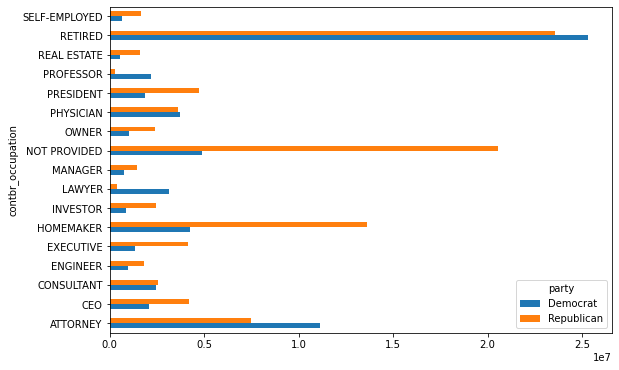

In [119]:
over_2mm.plot(kind='barh', figsize=(9, 6));

* You might be interested in the top donor occupations or top companies that donated
to Obama and Romney. To do this, you can group by candidate name and use a variant of the top method from earlier in the chapter:

In [121]:
def get_top_amounts(group, key, n=5):
    totals = group.groupby(key)['contb_receipt_amt'].sum()
    return totals.nlargest(n)

In [122]:
grouped = fec_mrbo.groupby('cand_nm')

grouped.apply(get_top_amounts, 'contbr_occupation', n=7)

cand_nm        contbr_occupation    
Obama, Barack  RETIRED                  25305116.38
               ATTORNEY                 11141982.97
               INFORMATION REQUESTED     4866973.96
               HOMEMAKER                 4248875.80
               PHYSICIAN                 3735124.94
                                           ...     
Romney, Mitt   HOMEMAKER                 8147446.22
               ATTORNEY                  5364718.82
               PRESIDENT                 2491244.89
               EXECUTIVE                 2300947.03
               C.E.O.                    1968386.11
Name: contb_receipt_amt, Length: 14, dtype: float64

In [123]:
grouped.apply(get_top_amounts, 'contbr_employer', n=10)

cand_nm        contbr_employer      
Obama, Barack  RETIRED                  22694358.85
               SELF-EMPLOYED            17080985.96
               NOT EMPLOYED              8586308.70
               INFORMATION REQUESTED     5053480.37
               HOMEMAKER                 2605408.54
                                           ...     
Romney, Mitt   CREDIT SUISSE              281150.00
               MORGAN STANLEY             267266.00
               GOLDMAN SACH & CO.         238250.00
               BARCLAYS CAPITAL           162750.00
               H.I.G. CAPITAL             139500.00
Name: contb_receipt_amt, Length: 20, dtype: float64

### Bucketing Donation Amounts

* A useful way to analyze this data is to use the cut function to discretize the contribu‐
tor amounts into buckets by contribution size

In [124]:
bins = np.array([0, 1, 10, 100, 1000, 10000,
                 100000, 1000000, 10000000])

labels = pd.cut(fec_mrbo['contb_receipt_amt'], bins)

labels

411         (10, 100]
412       (100, 1000]
413       (100, 1000]
414         (10, 100]
415         (10, 100]
             ...     
701381      (10, 100]
701382    (100, 1000]
701383        (1, 10]
701384      (10, 100]
701385    (100, 1000]
Name: contb_receipt_amt, Length: 694282, dtype: category
Categories (8, interval[int64]): [(0, 1] < (1, 10] < (10, 100] < (100, 1000] < (1000, 10000] < (10000, 100000] < (100000, 1000000] < (1000000, 10000000]]

#### We can then group the data for Obama and Romney by name and bin label to get a histogram by donation size

In [125]:
grouped = fec_mrbo.groupby(['cand_nm', labels])

grouped.size().unstack(0)

cand_nm,"Obama, Barack","Romney, Mitt"
contb_receipt_amt,,
"(0, 1]",493,77
"(1, 10]",40070,3681
"(10, 100]",372280,31853
"(100, 1000]",153991,43357
"(1000, 10000]",22284,26186
"(10000, 100000]",2,1
"(100000, 1000000]",3,0
"(1000000, 10000000]",4,0


* You can also sum the contribution amounts and normalize within buckets to visualize percentage of total donations of each size by candidate

In [127]:
bucket_sums = grouped['contb_receipt_amt'].sum().unstack(0)

normed_sums = bucket_sums.div(bucket_sums.sum(axis=1), axis=0)

normed_sums

cand_nm,"Obama, Barack","Romney, Mitt"
contb_receipt_amt,,
"(0, 1]",0.805182,0.194818
"(1, 10]",0.918767,0.081233
"(10, 100]",0.910769,0.089231
"(100, 1000]",0.710176,0.289824
"(1000, 10000]",0.447326,0.552674
"(10000, 100000]",0.823120,0.176880
"(100000, 1000000]",1.000000,NaN
"(1000000, 10000000]",1.000000,NaN


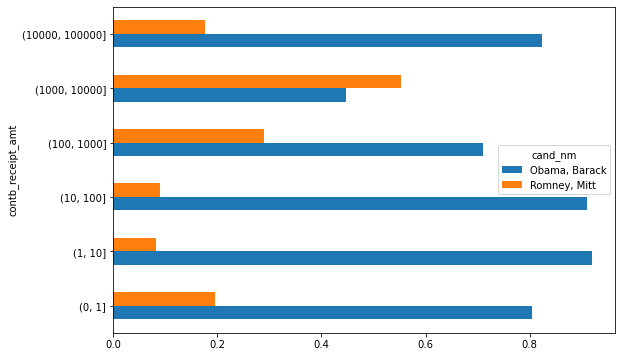

In [129]:
normed_sums[:-2].plot(kind='barh', figsize=(9, 6));

### Donation Statistics by State

In [130]:
grouped = fec_mrbo.groupby(['cand_nm', 'contbr_st'])

totals = grouped['contb_receipt_amt'].sum().unstack(0).fillna(0)

totals =  totals.loc[totals.sum(1) > 10000]

totals[:10]

cand_nm,"Obama, Barack","Romney, Mitt"
contbr_st,,
AA,56405.00,135.00
AE,42973.75,5680.00
AK,281840.15,86204.24
AL,543123.48,527303.51
AP,37130.50,1655.00
AR,359247.28,105556.00
AZ,1506476.98,1888436.23
CA,23824984.24,11237636.60
CO,2132429.49,1506714.12


In [131]:
percent = totals.div(totals.sum(1), axis=0)

percent[:10]

cand_nm,"Obama, Barack","Romney, Mitt"
contbr_st,,
AA,0.997612,0.002388
AE,0.883257,0.116743
AK,0.765778,0.234222
AL,0.507390,0.492610
AP,0.957329,0.042671
AR,0.772902,0.227098
AZ,0.443745,0.556255
CA,0.679498,0.320502
CO,0.585970,0.414030
